# Deep Learning with fashionMNIST

Since I have been studying the theory behind Deep Learning and Neural Networks for several weeks now, it was time for me to get some hands-on experience. One of the classic beginner projects involves the MNIST dataset containing pictures of hand-written digits. However, I was not very excited about this dataset, given how many examples and notebooks I have already seen using it. So I decided to change it up a little bit and use fashionMNIST, a dataset consisting of images of clothes on Zalando. It consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image and belongs to one of 10 classes. It thus has the exact same properties as the original MNIST dataset.      

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn

from dataset_fashionmnist import *
from visualize_data_fashionmnist import *
from train_fashionmnist import *
from models_fashionmnist import *
from testing_fashionmnist import *
from error_analysis_fashionmnist import *

import random
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Import Data

fasionMNIST is available on [Kaggle](https://www.kaggle.com/zalando-research/fashionmnist) from which I downloaded and imported it.

In [2]:
train = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
test = pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv')

In [3]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.shape, test.shape

((60000, 785), (10000, 785))

## Preprocessing Data

First, I split train.csv into a training and validation set, using `train_test_split` in sci-kit learn.

In [5]:
train, val = train_test_split(train, test_size=0.2, random_state=42, stratify=train['label'])

In [6]:
train.shape, val.shape

((48000, 785), (12000, 785))

I then convert the dataframes into tensors in order to handle them with PyTorch.

In [7]:
train_tns = torch.from_numpy(train.values)
val_tns = torch.from_numpy(val.values)
test_tns = torch.from_numpy(test.values)

In [8]:
train_tns.shape, val_tns.shape, test_tns.shape

(torch.Size([48000, 785]), torch.Size([12000, 785]), torch.Size([10000, 785]))

I store the labels in a separate tensor, which leaves me with two tensors - features and label - for each the training, validation and test set. I also normalize the pixel values, so that they take on values between 0 and 1 in order to make convergence faster.

In [9]:
train_features = train_tns[:, 1:].type(torch.FloatTensor)/255
val_features = val_tns[:, 1:].type(torch.FloatTensor)/255
test_features = test_tns[:, 1:].type(torch.FloatTensor)/255

train_features.shape, val_features.shape, test_features.shape

(torch.Size([48000, 784]), torch.Size([12000, 784]), torch.Size([10000, 784]))

In [10]:
train_labels = train_tns[:, 0]
val_labels = val_tns[:, 0]
test_labels = test_tns[:, 0]
train_labels.shape, val_labels.shape, test_labels.shape

(torch.Size([48000]), torch.Size([12000]), torch.Size([10000]))

Using the tensors including the features and labels, I build a training and validation dataset (using the script `dataset.py`).

In [11]:
train_ds = fashionMNISTDataset(train_features, train_labels, plot=False)
val_ds = fashionMNISTDataset(val_features, val_labels, plot=False)
test_ds = fashionMNISTDataset(test_features, test_labels, plot=False)

With the datasets I can now build a dataloader for both the training set.

In [12]:
batch_size = 250
train_dl = data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)

Let's have a look at a few example images:

In [13]:
X, y = next(iter(train_dl))

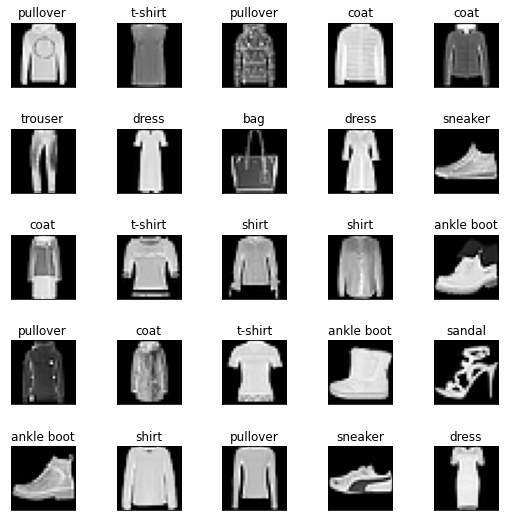

In [14]:
show_images(X.reshape(batch_size, 28,28), 5, 5, titles=get_label(y));

## Building a baseline model

The model serving as my baseline is a simple two fully connected layers (see `models.py`).

To see if my model works, I first train it with three epochs.

In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [16]:
in_dim, hidden_dim, out_dim = 784, 100, 10

NN(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
Ep: 1/3 | Train Loss: 0.7398 | Val Loss: 0.5177 | Val Acc: 0.8150
Ep: 2/3 | Train Loss: 0.4769 | Val Loss: 0.4436 | Val Acc: 0.8458
Ep: 3/3 | Train Loss: 0.4355 | Val Loss: 0.4195 | Val Acc: 0.8489
Best Validation Accuracy: 0.8489


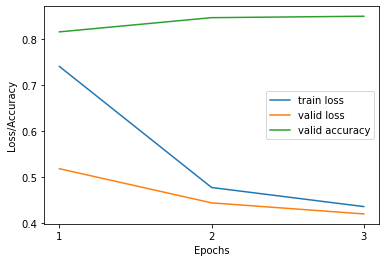

In [17]:
num_epochs = 3
learning_rate = 0.3

net = NN(in_dim, hidden_dim, out_dim)
print(net)

train_loss, valid_loss, acc = train_model(net, train_dl=train_dl, val_dl=val_dl, num_epochs=num_epochs, learning_rate=learning_rate, device=device)

Since this looks alright, I now train the model with 20 epochs and a learning rate of 0.1.

NN(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
Ep: 1/20 | Train Loss: 0.7350 | Val Loss: 0.5061 | Val Acc: 0.8246
Ep: 2/20 | Train Loss: 0.4747 | Val Loss: 0.4460 | Val Acc: 0.8428
Ep: 3/20 | Train Loss: 0.4297 | Val Loss: 0.4276 | Val Acc: 0.8486
Ep: 4/20 | Train Loss: 0.4003 | Val Loss: 0.3935 | Val Acc: 0.8625
Ep: 5/20 | Train Loss: 0.3826 | Val Loss: 0.3851 | Val Acc: 0.8643
Ep: 6/20 | Train Loss: 0.3641 | Val Loss: 0.3814 | Val Acc: 0.8637
Ep: 7/20 | Train Loss: 0.3526 | Val Loss: 0.3750 | Val Acc: 0.8658
Ep: 8/20 | Train Loss: 0.3429 | Val Loss: 0.3570 | Val Acc: 0.8691
Ep: 9/20 | Train Loss: 0.3310 | Val Loss: 0.3569 | Val Acc: 0.8727
Ep: 10/20 | Train Loss: 0.3230 | Val Loss: 0.3537 | Val Acc: 0.8721
Ep: 11/20 | Train Loss: 0.3135 | Val Loss: 0.3431 | Val Acc: 0.8759
Ep: 12/20 | Train Loss: 0.3045 | Val Loss: 0.3383 | Val Acc: 0.8785
Ep: 13/20 | Train Loss:

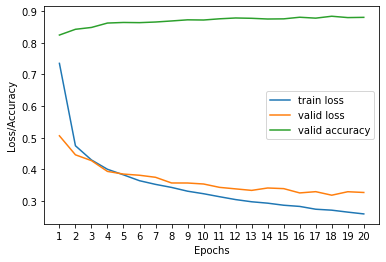

In [18]:
num_epochs = 20
learning_rate = 0.1

net = NN(in_dim, hidden_dim, out_dim)
print(net)

train_loss, valid_loss, acc = train_model(net, train_dl=train_dl, val_dl=val_dl, num_epochs=num_epochs, learning_rate=learning_rate, device=device, save_model=False)

## Building a CNN model

The baseline model is good, but a CNN model might work better, so I build three different CNN models (see `models.py`) and experimented with different architectures and hyperparameters.

The experiments I conducted where the following:

**1)**
model: CNN_1, lr=0.08, dropout=0.5
--> train loss = 0.0022, val loss = 0.5659, val acc = 0.9129

**2)**
model: CNN_2, lr=0.08, no dropout
--> train loss = 0.1069, val loss = 0.3010, val acc = 0.9051

**3)** 
model: CNN_2, lr=0.08, dropout=0.5
--> train loss = 0.3543, val loss = 0.3796, val acc = 0.8700

**4)** 
model: CNN_2, lr=0.08, dropout=0.3
--> train loss = 0.2703, val loss = 0.3103, val acc = 0.8911

**5)**
model: CNN_3, lr=0.01, dropout=0.5
--> train loss = 0.1136, val loss = 0.2801, val acc = 0.9116

**6)**
model: CNN_3, lr=0.05, dropout=0.5
--> train loss = 0.2772, val loss = 0.2373, val acc = 0.9139

**7)** 
model: CNN_3, lr=0.05, dropout=0.3
--> train loss = 0.2190, val loss = 0.2271, val acc = 0.9182

The last experiment resulted in the best accuracy while at the same time keeping the training and validation loss low and close to each other.

To train the CNN models with the data, it has to be reshaped. I then build a new Dataset and Dataloader.

In [19]:
train_features_cnn = train_features.reshape(-1, 1, 28, 28)
val_features_cnn = val_features.reshape(-1, 1, 28, 28)
test_features_cnn = test_features.reshape(-1, 1, 28, 28)

In [20]:
train_ds_cnn = fashionMNISTDataset(train_features_cnn, train_labels, plot=False)
val_ds_cnn = fashionMNISTDataset(val_features_cnn, val_labels, plot=False)
test_ds_cnn = fashionMNISTDataset(test_features_cnn, test_labels, plot=False)

In [21]:
batch_size=250
train_dl_cnn = data.DataLoader(train_ds_cnn, batch_size=batch_size, shuffle=True)
val_dl_cnn = data.DataLoader(val_ds_cnn, batch_size=batch_size, shuffle=False)
test_dl_cnn = data.DataLoader(test_ds_cnn, batch_size=batch_size, shuffle=False)

The following cell shows the training of the best model as a result from my experiments (see above)

CNN_3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (avg_pool): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
Ep: 1/1000 | Train Loss: 1.1070 | Val Loss: 0.7283 | Val Acc: 0.7108
Ep: 2/1000 | Train Loss: 0.6995 | Val Loss: 0.6037 | Val Acc: 0.7566
Ep: 3/1000 | Train Loss: 0.6192 | Val Loss: 0.5315 | Val Acc: 0.7910
Ep: 4/1000 | Train Loss: 0.5632 | Val Loss: 0.4793 | Val Acc: 0.8143
Ep: 5/1000 | Train Loss: 0.5275 | Val Loss: 0.4459 | Val Acc: 0.8283
Ep: 6/1000 | Train Loss: 0.4930 | Val Loss: 0.4241 | Val Acc: 0.8431
Ep: 7/1000 | Train Loss: 0.4694 | Val Loss: 0.3962 | Val Acc: 0.8535
Ep: 8/1000 | Train Loss: 0.4468 | Val Loss: 0.3801 | Val Acc: 0.8606
Ep: 9/1000 | Train Loss: 0.4315 | Val Loss: 0.3605 | Val Acc: 0.8697
Ep: 10

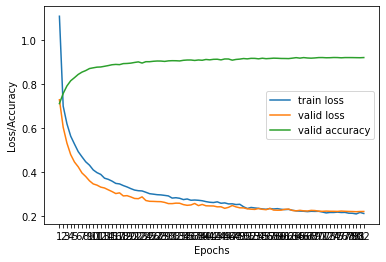

In [22]:
cnn_net = CNN_3()
print(cnn_net)

num_epochs = 1000
learning_rate=0.05

train_loss, valid_loss, acc = train_model(cnn_net, train_dl_cnn, val_dl_cnn, num_epochs, learning_rate, device, save_model=False)

## Testing the model

It's now to test the model from above using the training set. To do so, I first import and instantiate the pretrained and saved model.

In [23]:
model_testing_cnn = CNN_3()
model_testing_cnn.load_state_dict(torch.load('../input/best-model-fashion-mnist/best_model-2.pt'))
model_testing_cnn.eval()

CNN_3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (avg_pool): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [24]:
acc, preds, idx = test_model(model_testing_cnn, test_ds_cnn, device)

Test Loss: 0.2064, Test Accuracy: 0.9227


It looks like the model achieved an accuracy of 92.27% on the test set.

To get a little bit more insight into the results, I predict 25 random images from the test set and visualize them together with their predicted and true label, and the confidence of the prediction.

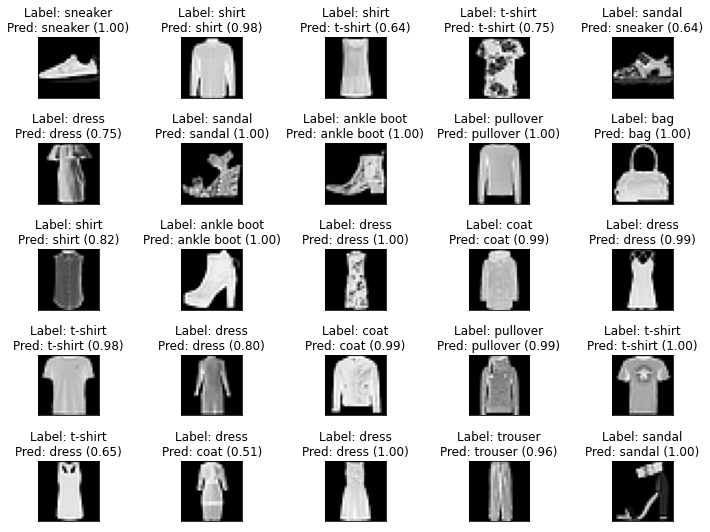

In [25]:
get_results(model = model_testing_cnn, test_ds_cnn=test_ds_cnn, batch_size=25)

## Error Analysis

In order to analyze the weaknesses of the model, I plot a confusion matrix and visualize the 25 worst predictions of the model.

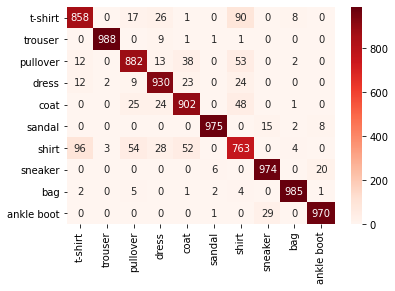

In [26]:
fn_confusion_matrix(test_ds_cnn.labels, preds);

According to the confusion matrix, the model frequently confuses shirts with t-shirts, pullovers and coats, sometimes also with dresses.

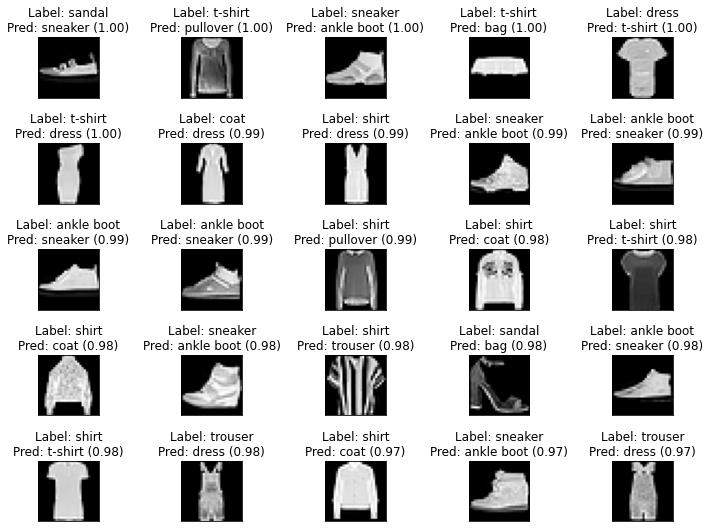

In [27]:
get_top_X_wrong_predictions(25, preds, idx, test_ds_cnn);

As can be seen above, the worst predictions (i.e. when the model output a wrong prediction with very high confidence) are quite difficult cases.